In [1]:
# general
import pandas as pd
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
import torch

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
cuda = torch.cuda.is_available()
print(torch.__version__)
print(cuda)

0.4.1
True


In [3]:
df_first = pd.read_csv('./data/etl_sum_bungae_acctit_452104.csv', sep='|')

In [4]:
zero = []
for col in df_first.columns:
    if df_first[col].sum() == 0:
        zero.append(col)
df_first = df_first.drop(zero, axis=1)
print(df_first.shape)

(42444, 476)


In [5]:
df_first.head(12)

,seq,no_com,biz_type,month,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,148,149,150,151,152,153,155,156,158,159,162,164,165,166,167,168,169,170,171,172,173,175,176,177,178,179,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,229,230,231,232,233,234,235,236,238,239,240,241,242,243,245,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,269,270,271,272,273,274,275,276,277,278,279,280,281,282,284,286,290,291,293,294,295,296,297,299,303,304,305,306,307,308,311,315,316,317,318,329,330,331,332,337,338,341,342,344,346,351,355,359,360,361,363,368,370,371,372,373,374,375,376,377,378,381,383,386,389,390,392,393,394,398,399,400,401,403,404,407,409,410,411,412,413,414,415,416,417,418,419,420,451,452,453,455,457,458,501,503,504,505,507,508,510,511,512,513,514,515,516,517,518,519,520,521,522,524,525,526,528,529,530,531,533,536,537,538,600,601,602,603,604,605,606,607,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,643,644,645,646,647,648,650,651,652,653,702,703,713,715,719,724,731,743,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,886,889,891,899,900,901,902,903,904,905,906,907,908,909,910,911,912,914,915,916,917,918,919,920,921,922,923,924,927,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,949,950,951,952,958,959,960,961,962,963,964,965,967,971,973,976,977,978,979,980,981,982,983,984,985,987,988,989,990,998,999
0,1,6173,452104,201501,214233459,-938541,-130535196,0,80909521,0,0,0,0,0,0,-202920000,0,0,0,0,0,0,0,9870110,0,0,0,0,0,0,0,0,0,0,0,0,-1931380,275564810,2366748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14400108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1015000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2057723,-73460,-4295287,0,0,0,0,0,734540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,194190660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14498727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23400000,0,0,0,0,0,0,24948000,0,0,0,0,0,170910,0,0,0,0,0,0,0,0,0,0,0,0,142605861,22032000,0,175440000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6000000,0,0,0,0,0,0,0,0,16603230,0,626340,386916,0,0,1201740,0,1650000,0,6330120,7643616,0,0,0,0,0,0,0,648960,17700,0,0,0,0,0,407940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,216570,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,6173,452104,201502,535003581,-938541,-129516882,0,-216569042,0,0,0,0,0,0,-202920000,0,0,0,0,0,0,0,9870110,0,0,0,0,0,0,0,0,0,0,0,0,-1931380,593564810,5482776,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14400108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1015000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6384434,159880,4043846,0,0,0,0,0,311840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,194190660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83391267,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23400000,0,0,0,0,0,0,1599000,0,0,0,0,0,416700,0,0,0,0,0,0,0,0,0,0,0,0,4590366,72000,0,26550000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6000000,0,0,0,0,0,0,0,0,2418060,10800,467400,547245,

In [6]:
external = pd.read_csv('./data/extern_variable.csv').fillna(0)

In [7]:
def tofloat(st):
    try:
        st = st.replace(',', '')
    except AttributeError:
        pass
    return float(st)

In [8]:
external = external.drop('0-2보일러등유', axis=1)
external[['13국내금(원g)','14금($온스)','15백금(NYMEX)','17팔라듐(NYMEX)','0-7알루미늄',
          '22납','23아연','24니켈','26주석','29대두','37코코아']] = external[[
              '13국내금(원g)','14금($온스)','15백금(NYMEX)','17팔라듐(NYMEX)','0-7알루미늄',
              '22납','23아연','24니켈','26주석','29대두','37코코아']].applymap(tofloat)

In [9]:
maechul_list = [str(a) for a in range(400, 421) if str(a) not in zero]
maechul = df_first[maechul_list].sum(axis=1)

remove = list(set(df_first['seq'].loc[maechul<0].values))
df_first = df_first[-df_first['seq'].isin(remove)]

In [10]:
external_ = pd.concat([external]*3003, axis=0)
maechul = maechul.loc[df_first.index]

In [11]:
index = np.arange(len(maechul))
maechul = pd.DataFrame(maechul)
maechul['index'] = index
maechul = maechul.set_index('index')

In [12]:

maechul_increment = []
for i in range(len(maechul)//12):
    for j in range(11):
        maechul_increment.append((maechul.loc[12*i+j+1].values[0] - 
                                  maechul.loc[12*i+j].values[0]) / 
                                  maechul.loc[12*i+j].values[0])

maechul_increment = pd.Series(maechul_increment).replace(np.inf, np.nan)
maechul_increment = maechul_increment.fillna(maechul_increment.dropna().quantile(0.99))


/home/kwp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys
/home/kwp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


In [13]:
# Cut by 5
for i in range(len(maechul_increment)):
    if maechul_increment.loc[i] > 5: 
        maechul_increment.loc[i] = 5

In [14]:
df_first.reset_index(drop=True, inplace=True)
external_.reset_index(drop=True, inplace=True)

df_first = pd.concat([df_first, external_], axis=1)

In [15]:
df_first = df_first[df_first['month'].isin(list(range(201601, 201612)) + list(range(201701, 201712)) + list(range(201501, 201512)))]

In [16]:
df_first.to_csv("./data/df_first.csv")

In [17]:
df_first.head(12)

,seq,no_com,biz_type,month,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,148,149,150,151,152,153,155,156,158,159,162,164,165,166,167,168,169,170,171,172,173,175,176,177,178,179,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,229,230,231,232,233,234,235,236,238,239,240,241,242,243,245,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,269,270,271,272,273,274,275,276,277,278,279,280,281,282,284,286,290,291,293,294,295,296,297,299,303,304,305,306,307,308,311,315,316,317,318,329,330,331,332,337,338,341,342,344,346,351,355,359,360,361,363,368,370,371,372,373,374,375,376,377,378,381,383,386,389,390,392,393,394,398,399,400,401,403,404,407,409,410,411,412,413,414,415,416,417,418,419,420,451,452,453,455,457,458,501,503,504,505,507,508,510,511,512,513,514,515,516,517,518,519,520,521,522,524,525,526,528,529,530,531,533,536,537,538,600,601,602,603,604,605,606,607,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,643,644,645,646,647,648,650,651,652,653,702,703,713,715,719,724,731,743,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,886,889,891,899,900,901,902,903,904,905,906,907,908,909,910,911,912,914,915,916,917,918,919,920,921,922,923,924,927,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,949,950,951,952,958,959,960,961,962,963,964,965,967,971,973,976,977,978,979,980,981,982,983,984,985,987,988,989,990,998,999,날짜,0-1실내등류,10휘발유,11고급휘발유,12경유,0-3CP(91일),0-4COFIX(단기),0-5미국국채10년,0-6미국국채30년,01콜금리,02CD(91일),03국고채권(3년),04회사채(무보증AA-),05COFIX(잔액),06COFIX(신규취급액),07WTI,08두바이,09브렌트,13국내금(원g),14금($온스),15백금(NYMEX),16은(COMEX),17팔라듐(NYMEX),0-7알루미늄,18가스오일,19난방유,20천연가스,21구리,22납,23아연,24니켈,26주석,27옥수수,28설탕,29대두,30대두박,31대두유,32면화,33소맥,34쌀,35오렌지쥬스,36커피,37코코아
0,1,6173,452104,201501,214233459,-938541,-130535196,0,80909521,0,0,0,0,0,0,-202920000,0,0,0,0,0,0,0,9870110,0,0,0,0,0,0,0,0,0,0,0,0,-1931380,275564810,2366748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14400108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1015000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2057723,-73460,-4295287,0,0,0,0,0,734540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,194190660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14498727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23400000,0,0,0,0,0,0,24948000,0,0,0,0,0,170910,0,0,0,0,0,0,0,0,0,0,0,0,142605861,22032000,0,175440000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6000000,0,0,0,0,0,0,0,0,16603230,0,626340,386916,0,0,1201740,0,1650000,0,6330120,7643616,0,0,0,0,0,0,0,648960,17700,0,0,0,0,0,407940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,216570,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,835.38,1407.15,1780.99,1188.71,1.80,1.58,1.9330,2.7558,1.49,1.65,1.56,2.04,1.88,1.72,33.62,31.70,35.99,43077.18,1116.4,872.3,14.23,497.50,1514.00,304.00,1.0551,2.298,2.064,1714.00,1616.00,8600.0,14645.0,372.00,13.14,882.38,272.4,30.88,60.99,479.38,11.350,132.40,116.35,2753.0
1,1,6173,452104,201502,535003581,-938541,-129516882,0,-216569042,0,0,0,0,0,0,-202920000,0,0,0,0,0,0,0,987011

In [18]:
#df_first = df_first.drop(['no_com', 'month', 'seq', 'biz_type','Unnamed: 0'], axis=1)
df_first = df_first.drop(['no_com', 'month', 'seq', 'biz_type', '101'], axis=1)
df_first.shape

(33033, 514)

In [19]:
scaler = StandardScaler()
df_first = scaler.fit_transform(df_first)

In [29]:
# 매출 증가량을 예측하기 위한 label 설정 (y)
# 본 예제에서 매출증가량은 11번째 컬럼임
X_first = []
y = maechul_increment
y_ = []

# 11개월 단위의 데이터가 존재하므로 11로 divide
for i in range(int(len(df_first)/11)):
    X_first.append(df_first[11*i : 11*i+11])
    y_.append(y[11*i : 11*i+11])

In [32]:
y = maechul_increment
X_first, y_ = [], []

for i in range(len(df_first)//11):
    X_first.append(df_first[11*i : 11*i+5])
    y_.append(y[11*i : 11*i+5])

val_first, val_y = [], []
for i in range(len(df_first)//11):
    val_first.append(df_first[11*i+5 : 11*i+10])
    val_y.append(y[11*i+5 : 11*i+10])

In [33]:
print(np.array(X_first).shape, np.array(y_).shape, np.array(val_first).shape, np.array(val_y).shape)

(3003, 5, 514) (3003, 5) (3003, 5, 514) (3003, 5)


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

In [30]:
if cuda:
    X_first = torch.from_numpy(np.array(X_first)).cuda().type(torch.cuda.FloatTensor)
    y_ = torch.from_numpy(np.array(y_)).cuda().type(torch.cuda.FloatTensor)

# 2015~2016: train, 2017: test
# 연도당 1001개의 데이터가 존재 0~2002, 2002~3003 까지 split
X_train, X_test = X_first[:2002], X_first[2002:] 
y_train, y_test = y_[:2002], y_[2002:]

In [34]:
if cuda:
    X_first = torch.from_numpy(np.array(X_first)).cuda().type(torch.cuda.FloatTensor)
    y_ = torch.from_numpy(np.array(y_)).cuda().type(torch.cuda.FloatTensor)
    val_first = torch.from_numpy(np.array(val_first)).cuda().type(torch.cuda.FloatTensor)
    val_y = torch.from_numpy(np.array(val_y)).cuda().type(torch.cuda.FloatTensor)

X_train, X_test = X_first, val_first
y_train, y_test = y_, val_y

In [35]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([3003, 5, 514]) torch.Size([3003, 5, 514]) torch.Size([3003, 5]) torch.Size([3003, 5])


In [36]:
# batch data append
# 배치크기가 나눠떨어지지 않을때 마지막 iteration에서 길이만큼 append 한다
def batch(tensor, batch_size):
    tensor_list = []
    length = tensor.shape[0]
    i = 0
    while True:
        if ((i+1)*batch_size >= length):
            tensor_list.append(tensor[i*batch_size:length])
            return tensor_list
        tensor_list.append(tensor[i*batch_size:(i+1)*batch_size])
        i += 1

In [37]:
class Estimator(object):
    def __init__(self, model):
        self.model = model

        
    def compile(self, optimizer, loss):
        self.optimizer, self.loss_f = optimizer, loss

        
    def _fit(self, X_list, y_list):
        '''
        X_list's size is an input data's size(splited).
        All data will be trained per a 1 epoch.
        '''
        #print('-'*20)
        loss_list, acc_list = [], []
        for X, y in zip(X_list, y_list):
            '''
            Here is training part.  batch_size 씩 train(to avoid mem-alloc error).
            '''
            X_v, y_v = Variable(X), Variable(y, requires_grad=False)
            
            #print(np.array(X_v).shape)
            
            self.optimizer.zero_grad()
            
            '''
            모델 객체로 데이터를 보내되, 전단계인 init h(t-1) 은 랜덤값으로 생성.
            '''
            y_pred = self.model(X_v, self.model.initHidden(X_v.size()[0]))
            #print(X_v.shape[1])
            #print(y_pred.shape[0])
            y_pred = y_pred.reshape(y_pred.shape[0], X_v.shape[1])
            
            #ny_pred = Variable(torch.zeros((y_v.size()))).cuda()
            #for i in range(X_v.size()[0]):
            #    for j in range(X_v.size()[1]):
            #        #ny_pred[i][j] = sum(y_pred[i][j])/len(y_pred[i][j])
            #        ny_pred[i][j] = torch.mean(y_pred[i][j])
            
            loss = sum([self.loss_f(y_pred[i], y_v[i]) for i in range(len(y_v))])/len(y_v)
            
            #print(y_v.shape)
            
            #loss = self.loss_f(y_pred, y_v)
            #loss = self.loss_f(ny_pred, y_v)
            
            loss.backward()
            self.optimizer.step()

            ## for log
            loss_list.append(loss.data[0])
            #classes = torch.topk(y_pred, 1)[1].data.numpy().flatten()
            #acc = self._accuracy(classes, y)
            #acc_list.append(acc)
        return sum(loss_list) / len(loss_list)#, sum(acc_list) / len(acc_list)

    
    def fit(self, X, y, batch_size, nb_epoch, validation_data=()):
        X_list, y_list = batch(X, batch_size), batch(y, batch_size)
        
        train_losses, val_losses = [], []
        for t in range(nb_epoch):

            loss = self._fit(X_list, y_list)  # TRAIN

            val_log = ''
            if validation_data:
                val_loss = self.evaluate(validation_data[0], validation_data[1], batch_size=batch_size)
                val_log = "- val_loss: %06.4f" % (val_loss)
            if ((t+1) % 5) == 0:
                print("Epoch %s/%s loss: %06.4f  %s" % ((t+1), nb_epoch, loss, val_log))
            train_losses.append(loss)
            val_losses.append(val_loss)        
        return train_losses, val_losses

    
    def evaluate(self, X, y, batch_size):
        y_pred = self.predict(X)
        y_pred = y_pred.reshape(y_pred.shape[0], X.shape[1])
        
        y_v = Variable(y, requires_grad=False)
        
        #ny_pred = Variable(torch.zeros((y_v.size()))).cuda()
        #for i in range(X.size()[0]):
        #    for j in range(X.size()[1]):
                #ny_pred[i][j] = sum(y_pred[i][j])/len(y_pred[i][j])
        #        ny_pred[i][j] = torch.mean(y_pred[i][j])
        
        loss = sum([self.loss_f(y_pred[i], y_v[i]) for i in range(len(y_v))])/len(y_v)
        #loss = self.loss_f(y_pred, y_v)
        #loss = self.loss_f(ny_pred, y_v)
        return loss.data[0]

    
    #def _accuracy(self, y_pred, y):        
    #    return sum(y_pred - y.reshape(10*y.shape[0])) / (10*y.shape[0])

    
    def predict(self, X):
        X = Variable(X)
        y_pred = self.model(X, self.model.initHidden(X.size()[0]))
        return y_pred

    
    def predict_classes(self, X):
        return torch.topk(self.predict(X), 1)[1].data.numpy().flatten()

In [50]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        # layer 1
        self.gru = nn.GRU(input_size, hidden_size, 
                          batch_first=True, 
                          num_layers=1, 
                          dropout=0.75)
        
        # linear layer activation function
        self.act = nn.LeakyReLU()
        
        # layer 2
        self.normalization = nn.LayerNorm(hidden_size)
        self.linear = nn.Linear(hidden_size, hidden_size2)
        
        # layer 3
        self.normalization2 = nn.LayerNorm(hidden_size2)
        self.linear2 = nn.Linear(hidden_size2, output_size)
        
        #self.softmax = nn.Softmax(dim=-1)

        
    def forward(self, input, hidden):
        out1, hn = self.gru(input, hidden)
        out2 = self.normalization(out1)
        out3 = self.normalization2(self.act(self.linear(out2)))
        out4 = self.linear2(out3)
        return out4
    

    def initHidden(self, N):
        return Variable(torch.randn(1, N, self.hidden_size).cuda())

In [51]:
input_size = 514
hidden_size = 512
hidden_size2 = 256
output_size = 1
EPOCH = 100
BATCH_SIZE = 100


model = GRU(input_size, hidden_size, hidden_size2, output_size)
if cuda:
    model = model.cuda()

reg = Estimator(model)
reg.compile(optimizer=torch.optim.Adam(model.parameters(), lr=25e-4), loss=nn.L1Loss())

train_losses, val_losses = reg.fit(X_train, y_train, 
                                   batch_size=BATCH_SIZE, 
                                   nb_epoch=EPOCH,
                                   validation_data=(X_test, y_test))
score = reg.evaluate(X_test, y_test, batch_size=BATCH_SIZE)


/home/kwp/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/kwp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/kwp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 5/100 loss: 1.7289  - val_loss: 2.0785
Epoch 10/100 loss: 1.4783  - val_loss: 2.1392
Epoch 15/100 loss: 1.1318  - val_loss: 2.1700
Epoch 20/100 loss: 0.9893  - val_loss: 2.2649
Epoch 25/100 loss: 0.8980  - val_loss: 2.2878
Epoch 30/100 loss: 0.7872  - val_loss: 2.4081
Epoch 35/100 loss: 0.7590  - val_loss: 2.4015
Epoch 40/100 loss: 0.7372  - val_loss: 2.4152
Epoch 45/100 loss: 0.7154  - val_loss: 2.4113
Epoch 50/100 loss: 0.6804  - val_loss: 2.4082
Epoch 55/100 loss: 0.7083  - val_loss: 2.4357
Epoch 60/100 loss: 0.6401  - val_loss: 2.4436
Epoch 65/100 loss: 0.6754  - val_loss: 2.5004
Epoch 70/100 loss: 0.5661  - val_loss: 2.5137
Epoch 75/100 loss: 0.5320  - val_loss: 2.4818
Epoch 80/100 loss: 0.5223  - val_loss: 2.5419
Epoch 85/100 loss: 0.4769  - val_loss: 2.5388
Epoch 90/100 loss: 0.4833  - val_loss: 2.5184
Epoch 95/100 loss: 0.4776  - val_loss: 2.5168
Epoch 100/100 loss: 0.4069  - val_loss: 2.5526


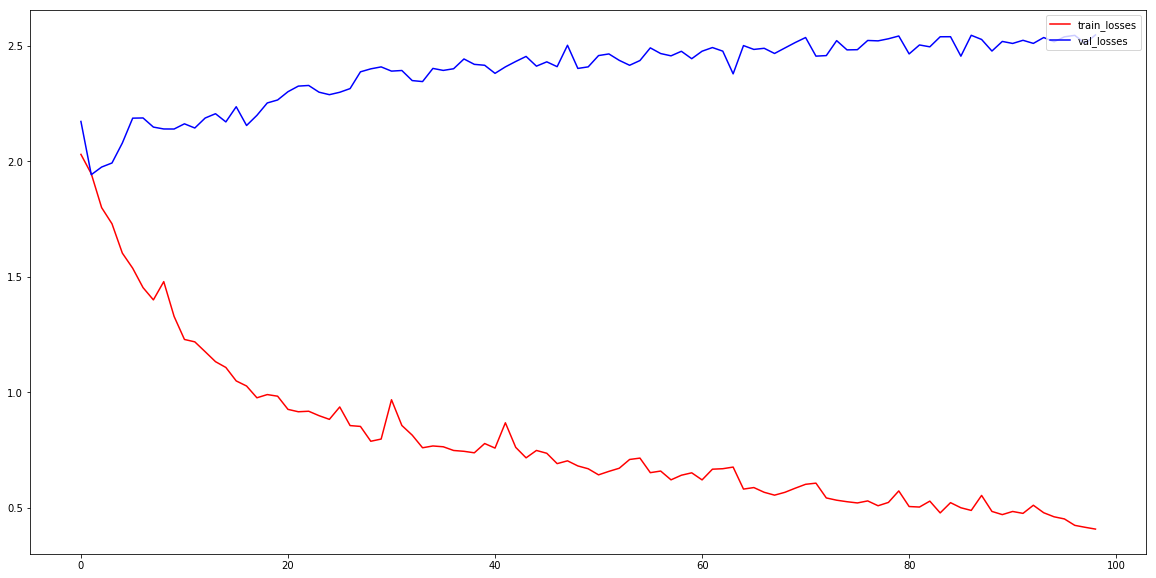

In [52]:
length = len(train_losses)-1

plt.figure(figsize=(20, 10))
plt.plot(np.arange(length), train_losses[1:], 'r')
plt.plot(np.arange(length), val_losses[:-1], 'b')
plt.legend(['train_losses', 'val_losses'],  loc='upper right')
plt.show()

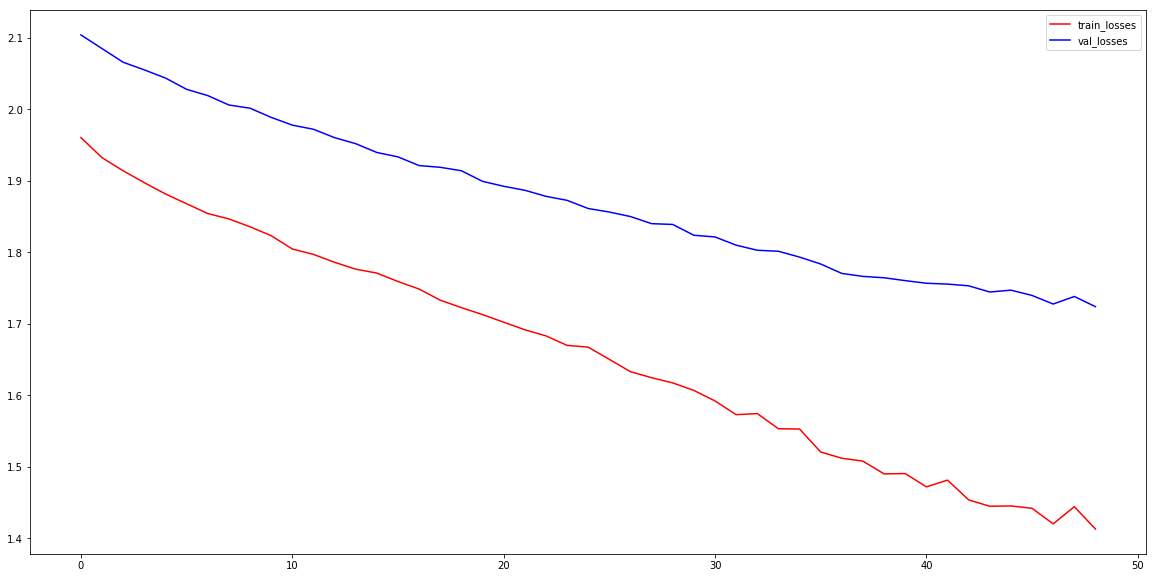

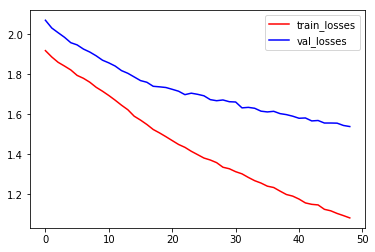

In [50]:
import matplotlib.pyplot as plt

length = len(train_losses)-1

plt.plot(np.arange(length), train_losses[1:], 'r')
plt.plot(np.arange(length), val_losses[:-1], 'b')
plt.legend(['train_losses', 'val_losses'],  loc='upper right')


plt.show()

In [51]:
prediction = reg.predict(X_test).reshape(np.array(y_test).shape)

for i in range(10):
    num = np.random.randint(len(y_test))
    x = np.arange(11)
    #x_ = np.arange(10)[1:]
    #x__ = np.arange(10)[5:]
    plt.figure(figsize=(10,10))
    
    plt.plot(x, prediction[num].detach().numpy(), 'b')
    #plt.plot(x_, prediction2[num].detach().numpy(), 'r')
    #plt.plot(x__, prediction5[num].detach().numpy(), 'b')
    plt.plot(x, y_test[num], 'c')
    
    plt.legend(['prediction', 'true'],  loc='upper right')
    plt.title('sample number = {}'.format(num))
    
    for a,b in zip(x, prediction[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    '''for a,b in zip(x_, prediction2[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    for a,b in zip(x__, prediction5[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)'''
        
    for a,b in zip(x, y_test[num]): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
    
    plt.show()

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 720x720 with 0 Axes>

In [186]:
prediction = reg.predict(X_test).reshape(np.array(y_test).shape)
y_test = (y_test - y_min*np.ones(y_test.shape))/y_max

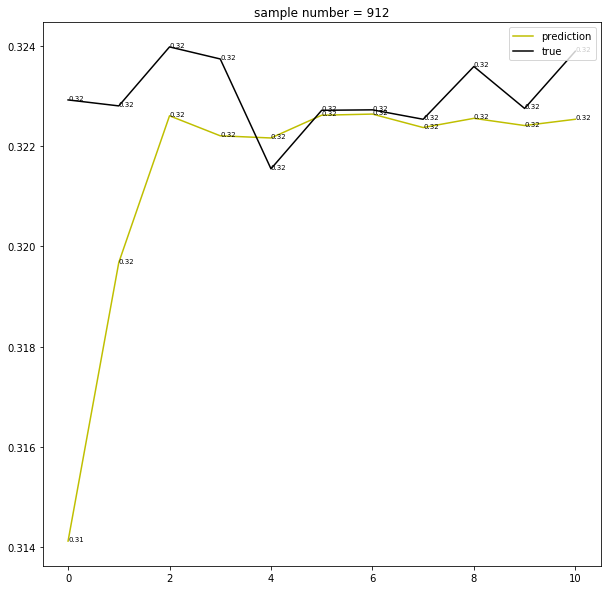

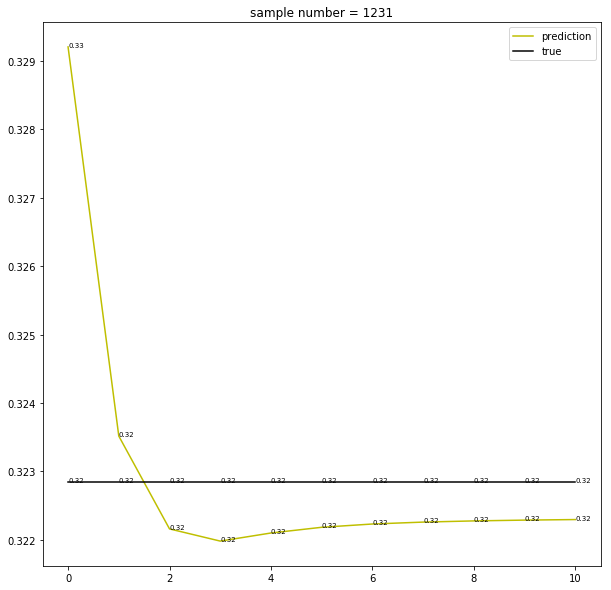

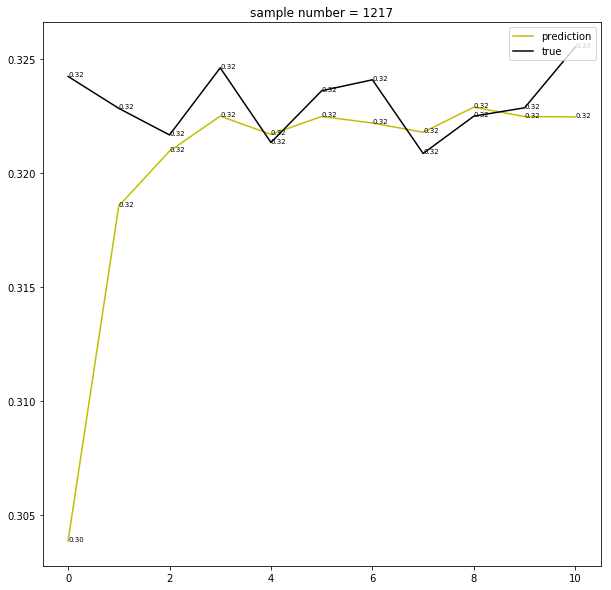

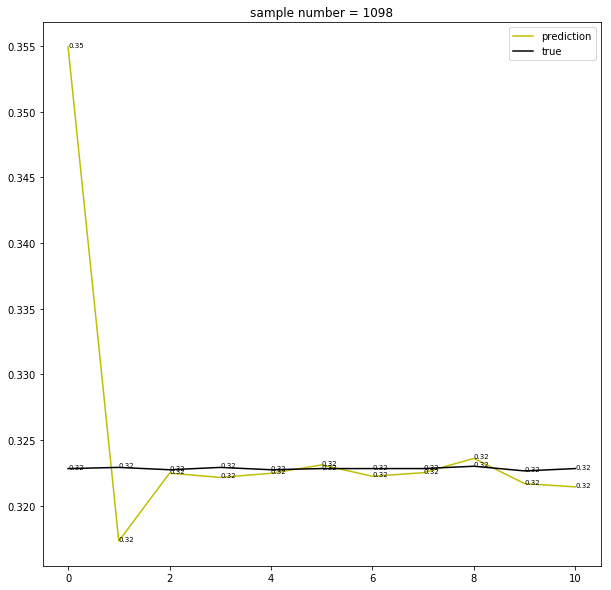

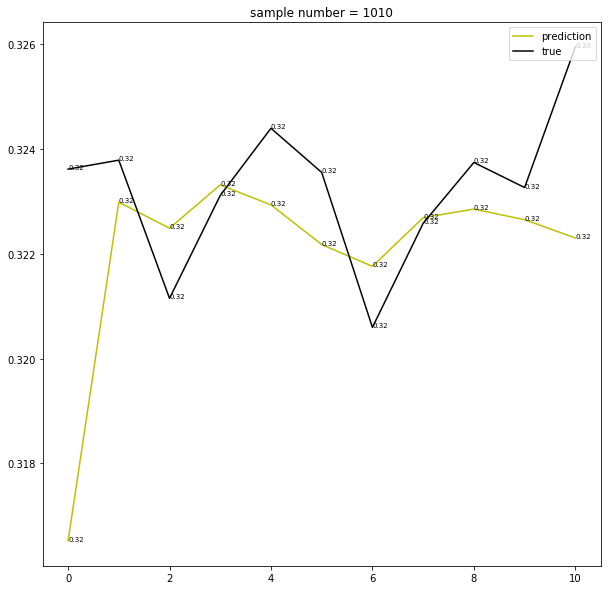

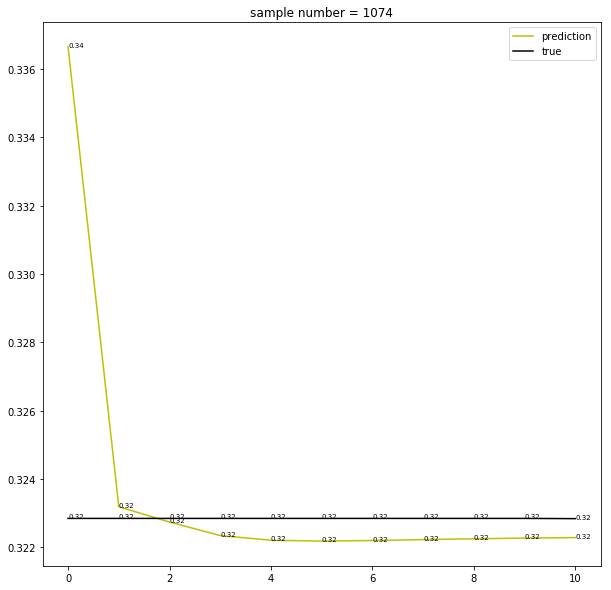

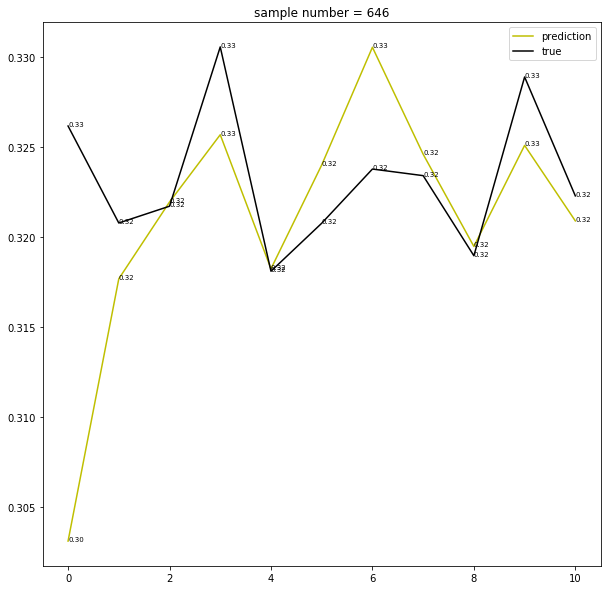

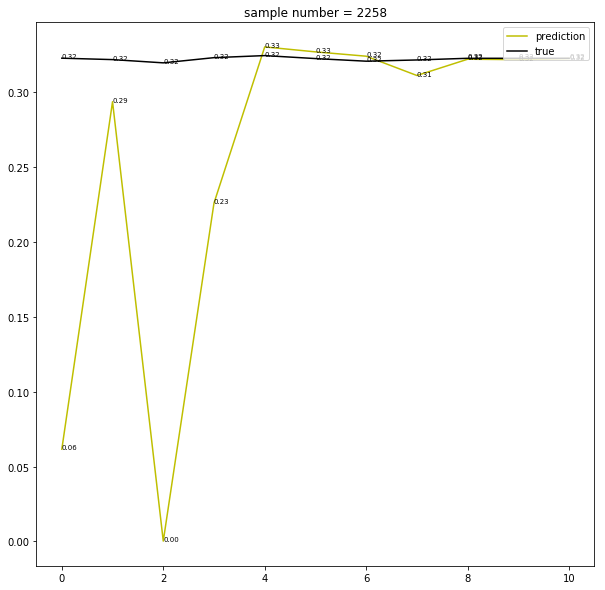

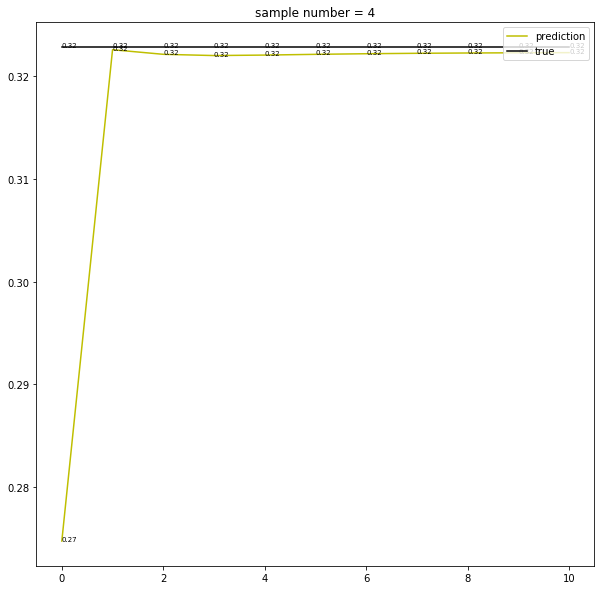

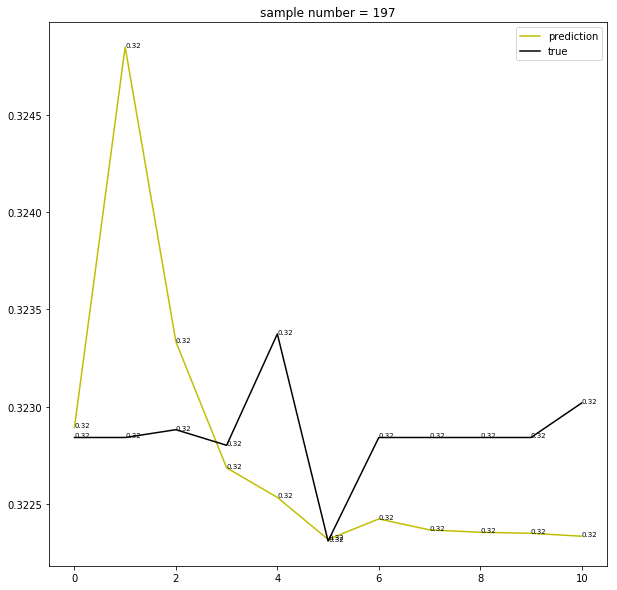

In [187]:
for i in range(10):
    num = np.random.randint(len(y_test))
    x = np.arange(11)
    #x_ = np.arange(10)[1:]
    #x__ = np.arange(10)[5:]
    plt.figure(figsize=(10,10))
    
    plt.plot(x, prediction[num].detach().numpy(), 'y')
    #plt.plot(x_, prediction2[num].detach().numpy(), 'r')
    #plt.plot(x__, prediction5[num].detach().numpy(), 'b')
    plt.plot(x, y_test[num], 'k')
    
    plt.legend(['prediction', 'true'],  loc='upper right')
    plt.title('sample number = {}'.format(num))
    
    for a,b in zip(x, prediction[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    '''for a,b in zip(x_, prediction2[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    for a,b in zip(x__, prediction5[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)'''
        
    for a,b in zip(x, y_test[num]): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
    
    plt.show()

In [179]:
prediction = reg.predict(X_test).reshape(np.array(y_test).shape)

In [180]:
y_min, y_max, _ = scaler2(maechul_increment)

In [181]:
prediction = prediction.detach().numpy()*y_max + np.ones(prediction.detach().numpy().shape)*y_min
y_test = np.array(y_test)
y_test = y_test*y_max + np.ones(y_test.shape)*y_min

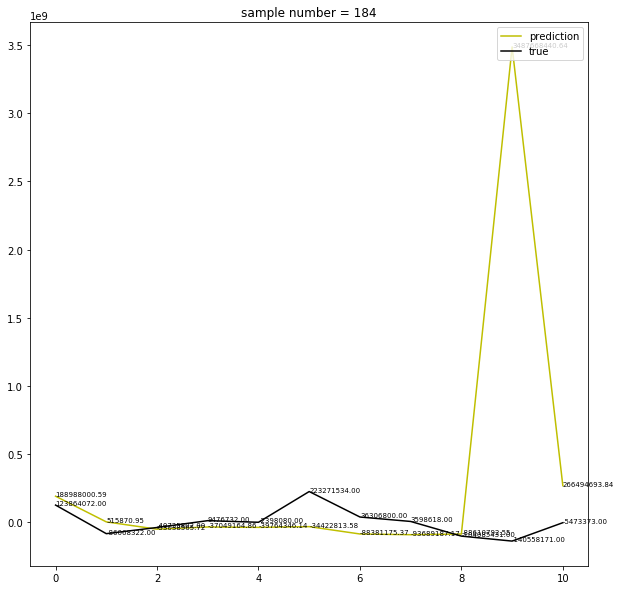

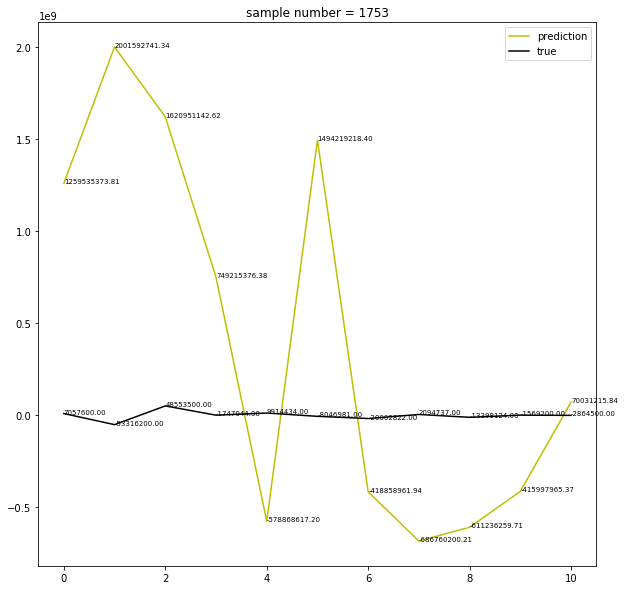

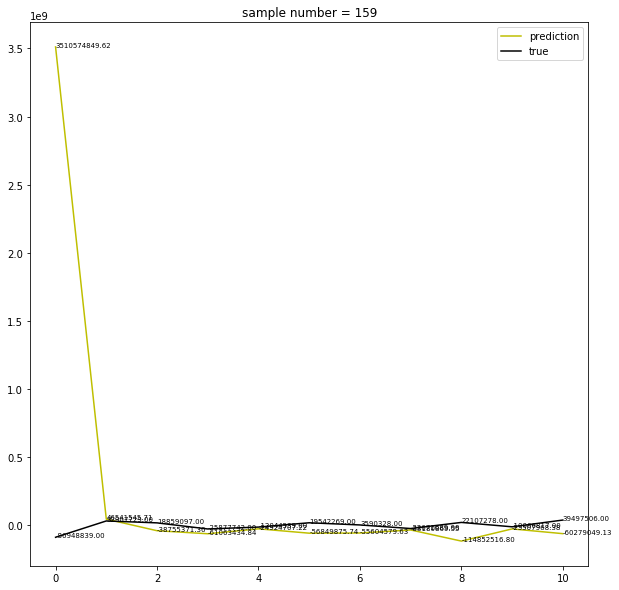

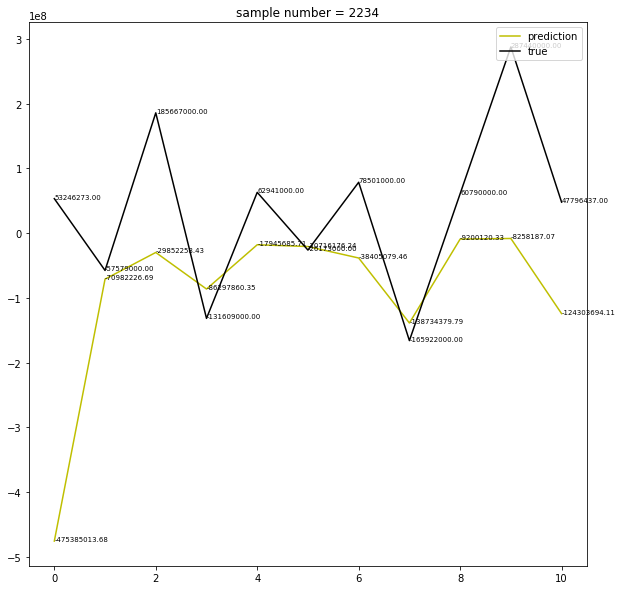

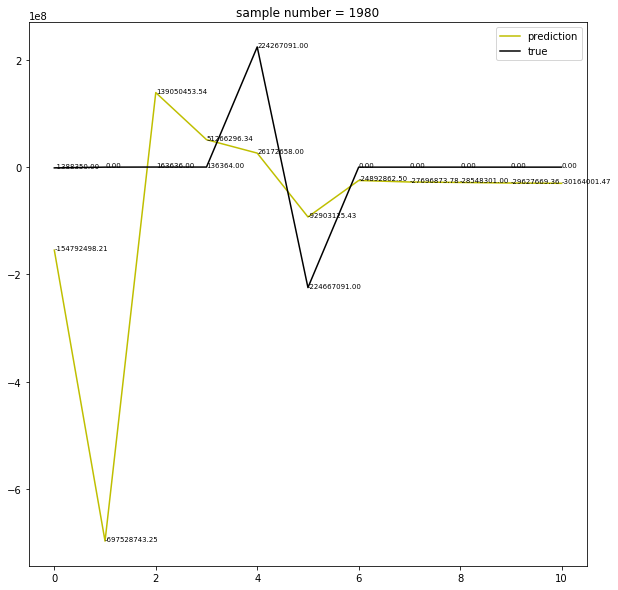

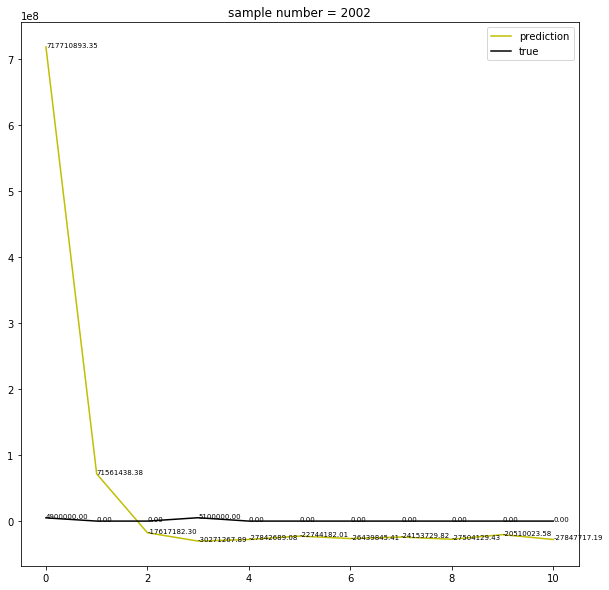

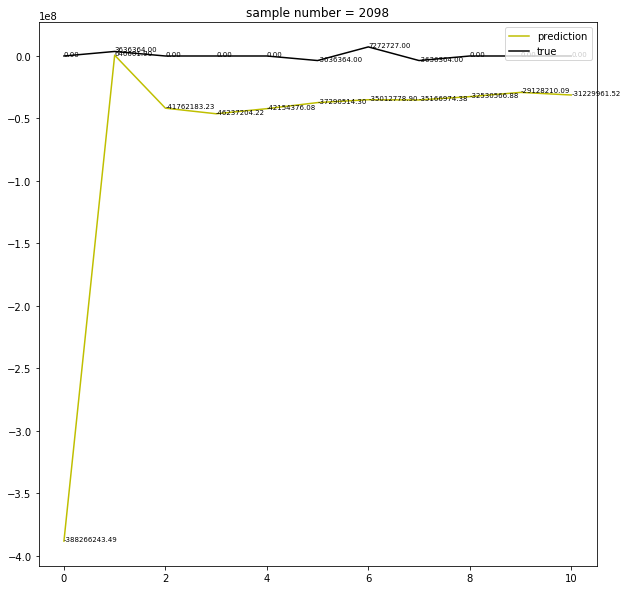

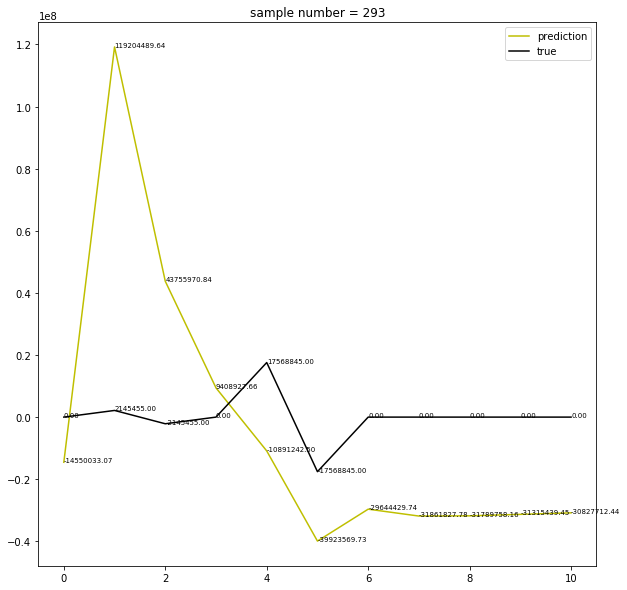

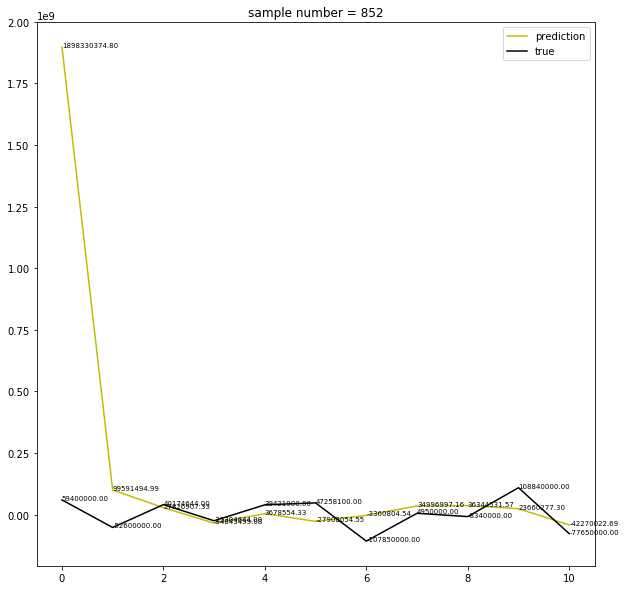

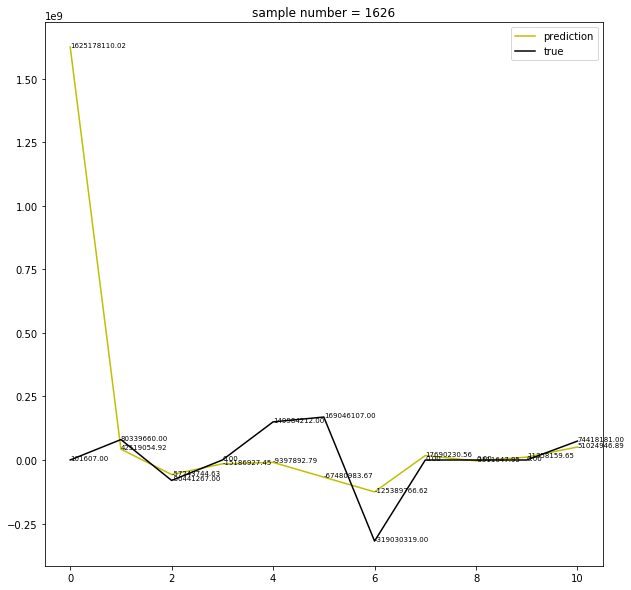

In [183]:
for i in range(10):
    num = np.random.randint(len(y_test))
    x = np.arange(11)
    #x_ = np.arange(10)[1:]
    #x__ = np.arange(10)[5:]
    plt.figure(figsize=(10,10))
    
    plt.plot(x, prediction[num], 'y')
    #plt.plot(x_, prediction2[num].detach().numpy(), 'r')
    #plt.plot(x__, prediction5[num].detach().numpy(), 'b')
    plt.plot(x, y_test[num], 'k')
    
    plt.legend(['prediction', 'true'],  loc='upper right')
    plt.title('sample number = {}'.format(num))
    
    for a,b in zip(x, prediction[num]): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    '''for a,b in zip(x_, prediction2[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    for a,b in zip(x__, prediction5[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)'''
        
    for a,b in zip(x, y_test[num]): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
    
    plt.show()

## 다음달 예측

In [252]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

In [253]:
torch.__version__

'0.4.0'

In [289]:
def batch(tensor, batch_size):
    tensor_list = []
    length = tensor.shape[0]
    i = 0
    while True:
        if (i+1) * batch_size >= length:
            tensor_list.append(tensor[i * batch_size: length])
            return tensor_list
        tensor_list.append(tensor[i * batch_size: (i+1) * batch_size])
        i += 1

In [290]:
BATCH_SIZE = 32
EPOCH = 1000

class Estimator(object):

    def __init__(self, model):
        self.model = model

    def compile(self, optimizer, loss):
        self.optimizer = optimizer
        self.loss_f = loss

    def _fit(self, X_list, y_list):
        """
        train one epoch
        """
        loss_list = []
        acc_list = []
        for X, y in zip(X_list, y_list):
            X_v = Variable(torch.FloatTensor(X))
            y_v = Variable(torch.FloatTensor(y), requires_grad=False)
            
            
            self.optimizer.zero_grad()
            y_pred = self.model(X_v, self.model.initHidden(X_v.size()[0]))
            y_pred = y_pred.reshape(y_pred.shape[0], 10)
            loss = sum([self.loss_f(y_pred[i], y_v[i]) for i in range(len(y_v))])/len(y_v)
            #print(y_pred.shape, y_v.shape)
            
            loss.backward()
            self.optimizer.step()

            ## for log
            loss_list.append(loss.data[0])
            #classes = torch.topk(y_pred, 1)[1].data.numpy().flatten()
            #acc = self._accuracy(classes, y)
            #acc_list.append(acc)

        return sum(loss_list) / len(loss_list)#, sum(acc_list) / len(acc_list)

    def fit(self, X, y, batch_size=BATCH_SIZE, nb_epoch=EPOCH, validation_data=()):
        X_list = batch(X, batch_size)
        y_list = batch(y, batch_size)
        #print(X_list[0], y_list[0])
        train_losses=[]
        val_losses=[]
        
        for t in range(1, nb_epoch + 1):
            loss = self._fit(X_list, y_list)
            val_log = ''
            if validation_data:
                val_loss = self.evaluate(validation_data[0], validation_data[1], batch_size)
                val_log = "- val_loss: %06.4f" % (val_loss)
            print("Epoch %s/%s loss: %06.4f  %s" % (t, nb_epoch, loss, val_log))
            train_losses.append(loss)
            val_losses.append(val_loss)
            
        return train_losses, val_losses

    def evaluate(self, X, y, batch_size=BATCH_SIZE):
        y_pred = self.predict(X)
        y_pred = y_pred.reshape(y_pred.shape[0], 10)
        
        y_v = Variable(torch.from_numpy(y).float(), requires_grad=False)
        loss = sum([self.loss_f(y_pred[i], y_v[i]) for i in range(len(y_v))])/len(y_v)

        return loss.data[0]

    #def _accuracy(self, y_pred, y):        
    #    return sum(y_pred - y.reshape(10*y.shape[0])) / (10*y.shape[0])

    def predict(self, X):
        X = Variable(torch.FloatTensor(X))
        y_pred = self.model(X, self.model.initHidden(X.size()[0]))
        return y_pred
    
    def predict_classes(self, X):
        return torch.topk(self.predict(X), 1)[1].data.numpy().flatten()

In [291]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size):
        super(GRU, self).__init__() # nn.Module 을 init 하면서 밑의 forward가 작동함. forward2 로 이름 변경시 작동 안함.

        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, dropout=0.3, num_layers=1)
        self.act = nn.PReLU()
        self.normalization = nn.LayerNorm(hidden_size)
        
        self.linear2 = nn.Linear(hidden_size2, output_size)
        self.linear = nn.Linear(hidden_size, hidden_size2)
        #self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, input, hidden):  # Should be overridden by all subclasses.
        out1, hn = self.gru(input, hidden)
        out2 = self.normalization(out1)
        out3 = self.act(self.linear(out2))
        out4 = self.linear2(out3)
        
        return out4

    def initHidden(self, N): # Weight 생성
        return Variable(torch.randn(1, N, self.hidden_size))

In [292]:
input_size = 69
hidden_size = 32
hidden_size2 = 16
output_size = 1
EPOCH = 200
BATCH_SIZE = 32


model = GRU(input_size, hidden_size, hidden_size2, output_size)

reg = Estimator(model)
reg.compile(optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
            loss=nn.L1Loss())

train_losses, val_losses = reg.fit(np.array(X_train), np.array(y_train), batch_size=BATCH_SIZE, nb_epoch=EPOCH,
        validation_data=(np.array(X_test), np.array(y_test)))
score= reg.evaluate(np.array(X_test), np.array(y_test))

/Users/user/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


NotImplementedError: 

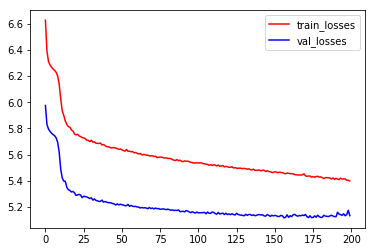

In [258]:
import matplotlib.pyplot as plt

length = len(train_losses)

plt.plot(np.arange(length), train_losses, 'r')
plt.plot(np.arange(length), val_losses, 'b')
plt.legend(['train_losses', 'val_losses'],  loc='upper right')


plt.show()

In [259]:
prediction = reg.predict(X_test).reshape(np.array(y_test).shape)

## 다다음달 예측

In [260]:
BATCH_SIZE = 32
EPOCH = 1000

class Estimator(object):

    def __init__(self, model):
        self.model = model

    def compile(self, optimizer, loss):
        self.optimizer = optimizer
        self.loss_f = loss

    def _fit(self, X_list, y_list):
        """
        train one epoch
        """
        loss_list = []
        acc_list = []
        for X, y in zip(X_list, y_list):
            X_v = Variable(torch.FloatTensor(X))
            y_v = Variable(torch.FloatTensor(y), requires_grad=False)
            
            
            self.optimizer.zero_grad()
            y_pred = self.model(X_v, self.model.initHidden(X_v.size()[0]))
            y_pred = y_pred.reshape(y_pred.shape[0], 9)
            loss = sum([self.loss_f(y_pred[i], y_v[i]) for i in range(len(y_v))])/len(y_v)
            #print(y_pred.shape, y_v.shape)
            
            loss.backward()
            self.optimizer.step()

            ## for log
            loss_list.append(loss.data[0])
            #classes = torch.topk(y_pred, 1)[1].data.numpy().flatten()
            #acc = self._accuracy(classes, y)
            #acc_list.append(acc)

        return sum(loss_list) / len(loss_list)#, sum(acc_list) / len(acc_list)

    def fit(self, X, y, batch_size=BATCH_SIZE, nb_epoch=EPOCH, validation_data=()):
        X_list = batch(X, batch_size)
        y_list = batch(y, batch_size)
        #print(X_list[0], y_list[0])
        train_losses=[]
        val_losses=[]
        
        for t in range(1, nb_epoch + 1):
            loss = self._fit(X_list, y_list)
            val_log = ''
            if validation_data:
                val_loss = self.evaluate(validation_data[0], validation_data[1], batch_size)
                val_log = "- val_loss: %06.4f" % (val_loss)
            print("Epoch %s/%s loss: %06.4f  %s" % (t, nb_epoch, loss, val_log))
            train_losses.append(loss)
            val_losses.append(val_loss)
            
        return train_losses, val_losses

    def evaluate(self, X, y, batch_size=BATCH_SIZE):
        y_pred = self.predict(X)
        y_pred = y_pred.reshape(y_pred.shape[0], 9)
        
        y_v = Variable(torch.from_numpy(y).float(), requires_grad=False)
        loss = sum([self.loss_f(y_pred[i], y_v[i]) for i in range(len(y_v))])/len(y_v)

        return loss.data[0]

    #def _accuracy(self, y_pred, y):        
    #    return sum(y_pred - y.reshape(10*y.shape[0])) / (10*y.shape[0])

    def predict(self, X):
        X = Variable(torch.FloatTensor(X))
        y_pred = self.model(X, self.model.initHidden(X.size()[0]))
        return y_pred
    
    def predict_classes(self, X):
        return torch.topk(self.predict(X), 1)[1].data.numpy().flatten()

In [261]:
# for next 2 month prediction

input_size = 69
hidden_size = 32
hidden_size2 = 16
output_size = 1
EPOCH = 200
BATCH_SIZE = 32


model = GRU(input_size, hidden_size, hidden_size2, output_size)

reg2 = Estimator(model)
reg2.compile(optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
            loss=nn.L1Loss())

train_losses, val_losses = reg2.fit(np.array(X_train2), np.array(y_train2), batch_size=BATCH_SIZE, nb_epoch=EPOCH,
        validation_data=(np.array(X_test2), np.array(y_test2)))
score= reg2.evaluate(np.array(X_test2), np.array(y_test2))

/Users/user/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/Users/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1/200 loss: 6.2102  - val_loss: 4.3636
Epoch 2/200 loss: 6.1021  - val_loss: 4.3044
Epoch 3/200 loss: 6.0468  - val_loss: 4.2671
Epoch 4/200 loss: 5.9883  - val_loss: 4.2059
Epoch 5/200 loss: 5.9265  - val_loss: 4.1476
Epoch 6/200 loss: 5.8509  - val_loss: 4.0744
Epoch 7/200 loss: 5.7764  - val_loss: 4.0029
Epoch 8/200 loss: 5.7244  - val_loss: 3.9570
Epoch 9/200 loss: 5.6902  - val_loss: 3.9183
Epoch 10/200 loss: 5.6534  - val_loss: 3.8978
Epoch 11/200 loss: 5.6308  - val_loss: 3.8753
Epoch 12/200 loss: 5.6029  - val_loss: 3.8575
Epoch 13/200 loss: 5.5829  - val_loss: 3.8379
Epoch 14/200 loss: 5.5664  - val_loss: 3.8301
Epoch 15/200 loss: 5.5474  - val_loss: 3.8063
Epoch 16/200 loss: 5.5316  - val_loss: 3.8088
Epoch 17/200 loss: 5.5239  - val_loss: 3.7840
Epoch 18/200 loss: 5.5044  - val_loss: 3.7596
Epoch 19/200 loss: 5.4990  - val_loss: 3.7741
Epoch 20/200 loss: 5.4885  - val_loss: 3.7578
Epoch 21/200 loss: 5.4796  - val_loss: 3.7530
Epoch 22/200 loss: 5.4778  - val_loss: 3.75

Epoch 179/200 loss: 5.2944  - val_loss: 3.7133
Epoch 180/200 loss: 5.2935  - val_loss: 3.7285
Epoch 181/200 loss: 5.2911  - val_loss: 3.7203
Epoch 182/200 loss: 5.2921  - val_loss: 3.7206
Epoch 183/200 loss: 5.2911  - val_loss: 3.7234
Epoch 184/200 loss: 5.2845  - val_loss: 3.7128
Epoch 185/200 loss: 5.2850  - val_loss: 3.7341
Epoch 186/200 loss: 5.2881  - val_loss: 3.7251
Epoch 187/200 loss: 5.2849  - val_loss: 3.7210
Epoch 188/200 loss: 5.2883  - val_loss: 3.7240
Epoch 189/200 loss: 5.2864  - val_loss: 3.7276
Epoch 190/200 loss: 5.2806  - val_loss: 3.7313
Epoch 191/200 loss: 5.2867  - val_loss: 3.7383
Epoch 192/200 loss: 5.2865  - val_loss: 3.7317
Epoch 193/200 loss: 5.2853  - val_loss: 3.7220
Epoch 194/200 loss: 5.2782  - val_loss: 3.7316
Epoch 195/200 loss: 5.2815  - val_loss: 3.7331
Epoch 196/200 loss: 5.2876  - val_loss: 3.7386
Epoch 197/200 loss: 5.2832  - val_loss: 3.7169
Epoch 198/200 loss: 5.2834  - val_loss: 3.7171
Epoch 199/200 loss: 5.2812  - val_loss: 3.7333
Epoch 200/200

In [262]:
prediction2 = reg2.predict(X_test2).reshape(np.array(y_test2).shape)

In [263]:
y_test[0]

72910    0.558208
72911   -2.641763
72912   -1.418092
72913    0.176730
72914   -2.849813
72915   -2.301101
72916   -0.293023
72917   -3.414474
72918   -1.303215
72919    0.065307
Name: 매출증가량, dtype: float64

In [264]:
prediction5

tensor([[-1.2755,  0.7553, -3.3235, -1.8139,  0.0152],
        [-1.7636,  0.4908, -2.9465, -1.3827,  0.4488],
        [-1.4341,  0.3657, -2.7882, -1.2886, -0.5941],
        ...,
        [-1.4975,  0.5148, -2.8982, -1.5962, -0.4638],
        [-1.8029, -0.1139, -2.2013, -1.5543,  0.0805],
        [-1.3827,  0.3935, -2.3096, -0.5000, -0.4600]])

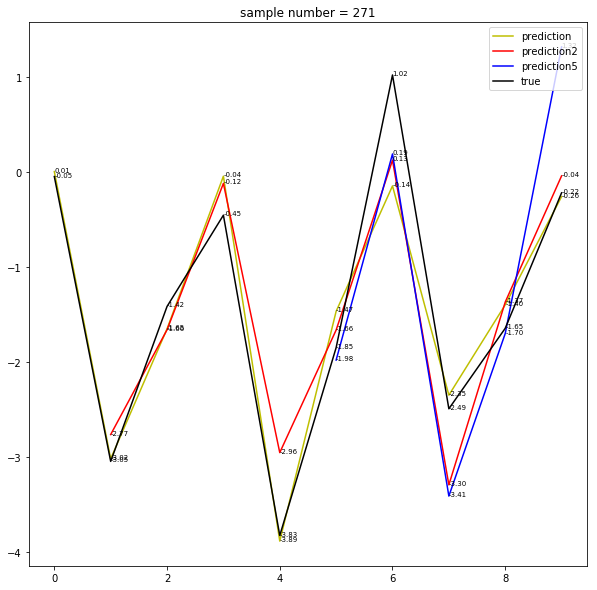

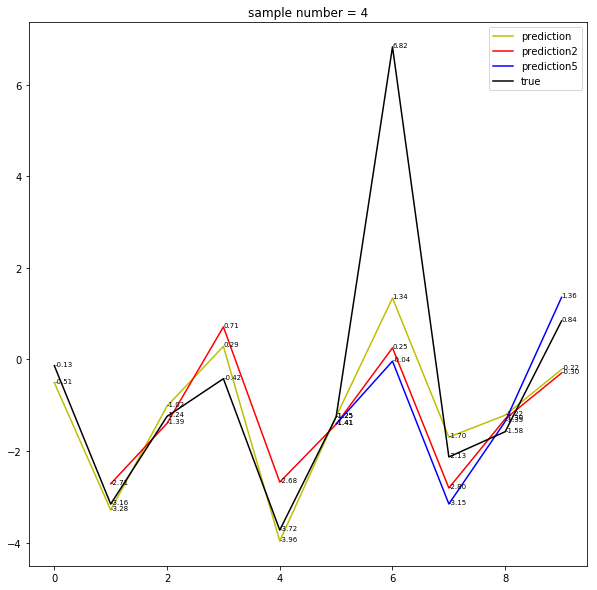

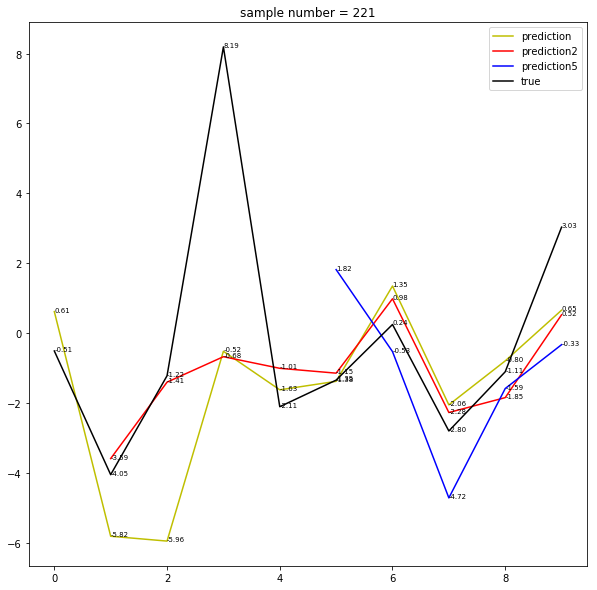

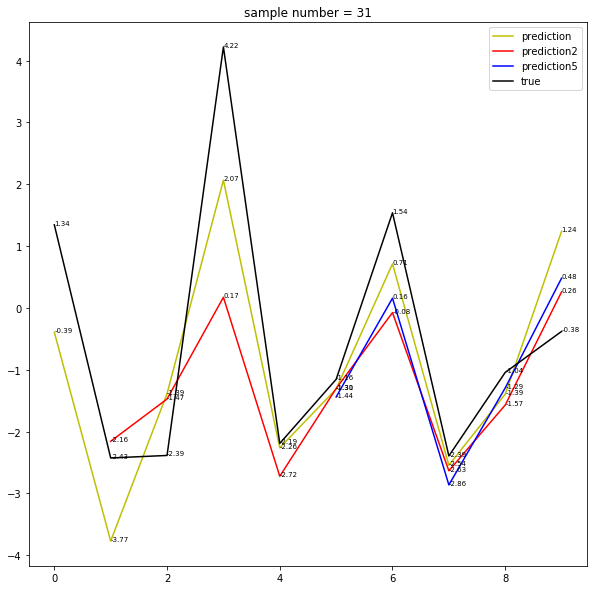

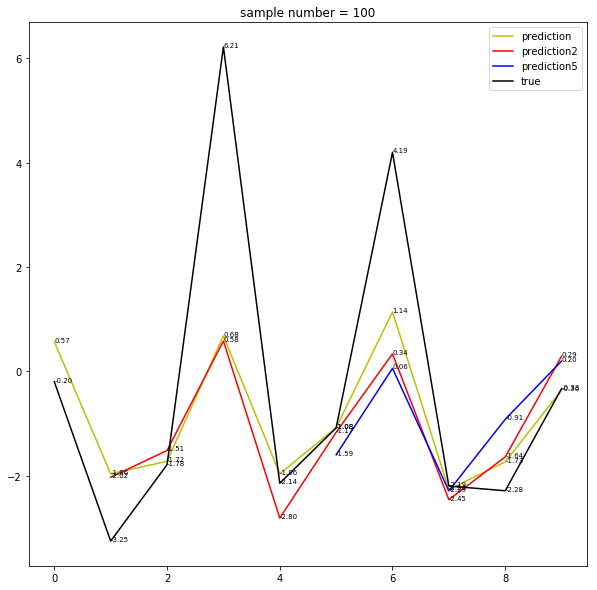

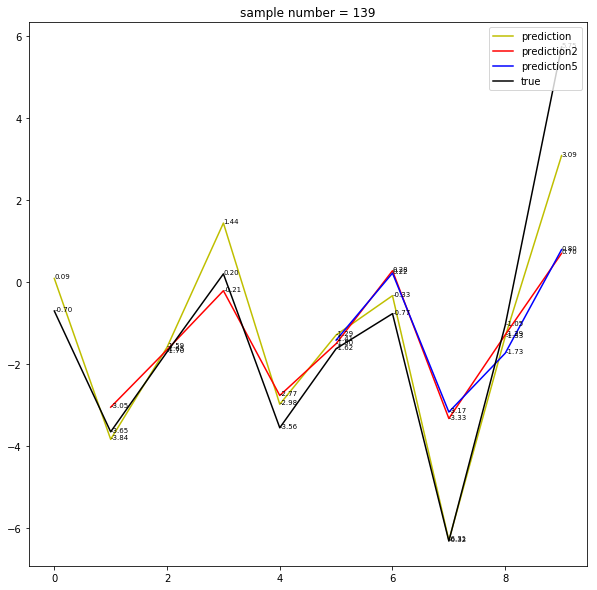

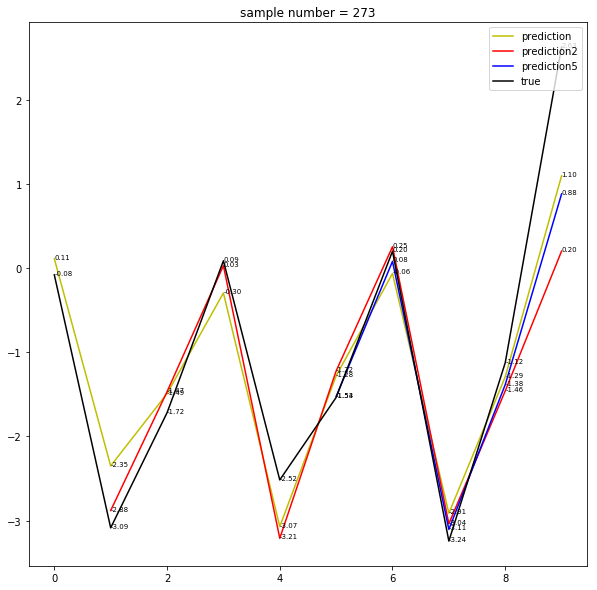

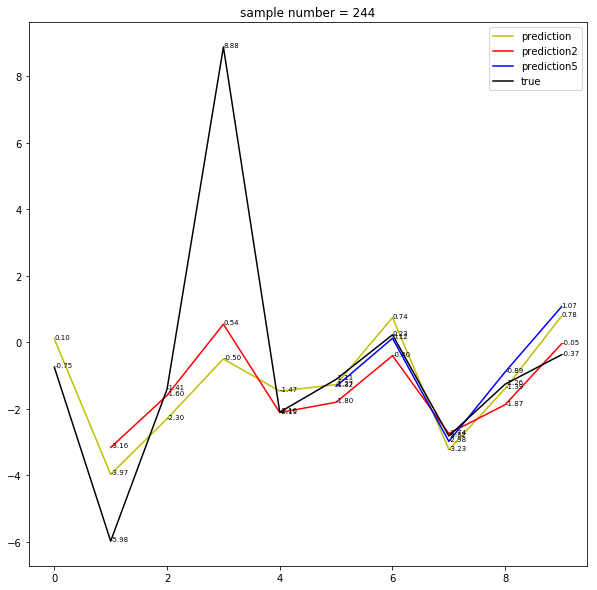

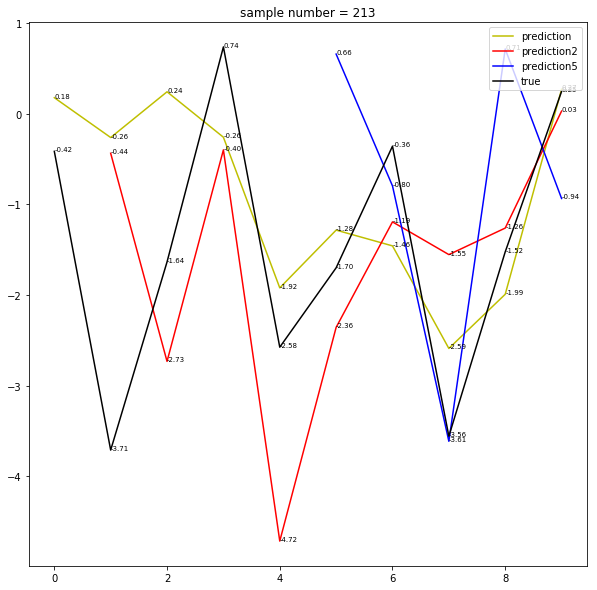

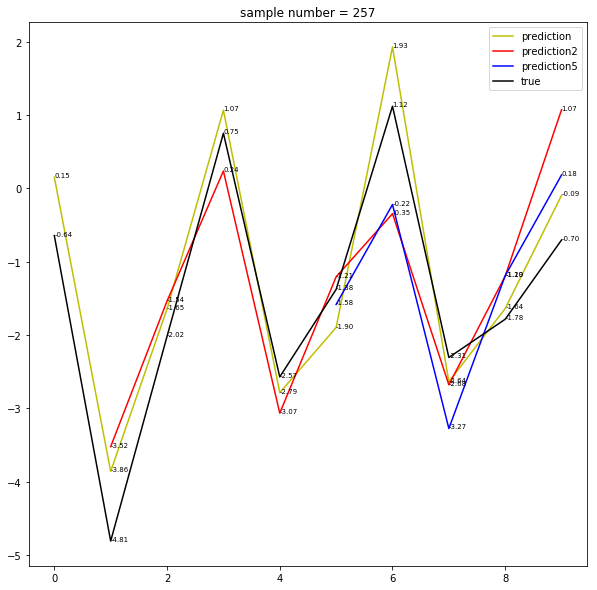

In [269]:
for i in range(10):
    num = np.random.randint(len(y_test))
    x = np.arange(10)
    x_ = np.arange(10)[1:]
    x__ = np.arange(10)[5:]
    plt.figure(figsize=(10,10))
    
    plt.plot(x, prediction[num].detach().numpy(), 'y')
    plt.plot(x_, prediction2[num].detach().numpy(), 'r')
    plt.plot(x__, prediction5[num].detach().numpy(), 'b')
    plt.plot(x, y_test[num].values, 'k')
    
    plt.legend(['prediction', 'prediction2', 'prediction5', 'true'],  loc='upper right')
    plt.title('sample number = {}'.format(num))
    
    for a,b in zip(x, prediction[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    for a,b in zip(x_, prediction2[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    for a,b in zip(x__, prediction5[num].detach().numpy()): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
        
    for a,b in zip(x, y_test[num].values): 
        plt.text(a, b, '{0:.2f}'.format(b), fontsize=7)
    
    plt.show()